## <div style="font-family: san-serif, ariel; font-size: 25px; background-color: aliceblue; text-align: center;"> Importing Libraries</div>

In [1]:
!pip install -q contractions
!pip install -q tensorflow
!pip install -q nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 5.6 MB/s eta 0:00:00


In [2]:
from textblob import Word
import nltk
nltk.data.path.append("/kaggle/working/")
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# library for data manipulation
import numpy as np
import pandas as pd
import polars as pl

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.5)
sns.set(rc={'axes.facecolor': '#FFFAF0', 'figure.facecolor': 'FFfAF0'})
sns.set_context("poster", font_scale=0.7)

In [4]:
# preprocessing
import contractions
from sklearn.feature_extraction.text import  (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import math
from gensim.models import Word2Vec
from textblob import TextBlob
from scipy.sparse import lil_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import pos_tag


2025-04-13 12:52:32.701154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744548752.961392      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744548753.039133      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# model building
from tensorflow.keras.regularizers import l2
import tensorflow
import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import (
    SimpleRNN, LSTM, GRU, Embedding, 
    Dense,  SpatialDropout1D, Dropout, BatchNormalization,
    Bidirectional, Attention
)
from sklearn.metrics import accuracy_score
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

# <div style="background-color: aliceblue; text-align: center; font-family: san-serif, arial; border-radius: 25px;">Loading Dataset<div>

In [6]:
df = pl.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df

review,sentiment
str,str
"""One of the other reviewers has…","""positive"""
"""A wonderful little production.…","""positive"""
"""I thought this was a wonderful…","""positive"""
"""Basically there's a family whe…","""negative"""
"""Petter Mattei's ""Love in the T…","""positive"""
…,…
"""I thought this movie did a dow…","""positive"""
"""Bad plot, bad dialogue, bad ac…","""negative"""
"""I am a Catholic taught in paro…","""negative"""


# <div style="background-color: aliceblue; text-align: center; font-family: san-serif, arial; border-radius: 25px;">Data Wrangling<div>

 1. Computing Dimension of Dataset
 2. Statistical Summary of Dataset
 3. Checking if there's any duplicate records
 4. computating no. missing values and the percentage of missing values
 5. performing descriptive analysis

In [7]:
# step 1
print(f"dataset shape = {df.shape}\n")
# step 2
print(f"Overview of dataset: \n {df.schema}\nNull Count: \n{df.null_count()}\n")
# step 3
print(f"Checking duplicated records: {df.is_duplicated().sum()}")
print(f"Peform Drop Duplicates: \n")
df = df.unique()
print(f"After gdropping duplicates: {df.shape}")
print(f"Finished Dropping Duplicates")

dataset shape = (50000, 2)

Overview of dataset: 
 Schema([('review', String), ('sentiment', String)])
Null Count: 
shape: (1, 2)
┌────────┬───────────┐
│ review ┆ sentiment │
│ ---    ┆ ---       │
│ u32    ┆ u32       │
╞════════╪═══════════╡
│ 0      ┆ 0         │
└────────┴───────────┘

Checking duplicated records: 824
Peform Drop Duplicates: 

After gdropping duplicates: (49582, 2)
Finished Dropping Duplicates


In [8]:
# step 4
missing_data = df.null_count()
missing_data = missing_data.melt(
    variable_name="",
    value_name="Total"
)
missing_data 

,Total
str,u32
"""review""",0
"""sentiment""",0


In [9]:
string_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in (pl.Utf8, pl.Categorical)]
df.select('sentiment').drop_nulls().to_series().value_counts().sort('count',descending=True)

sentiment,count
str,u32
"""positive""",24884
"""negative""",24698


In [10]:
# step 5
string_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in (pl.Utf8, pl.Categorical)]
summary = []
for col in string_cols:
    col_data = df.select(col)
    col_summary = {
        "column": col,
        "count": col_data.drop_nulls().height,
        "unique": col_data.unique().height,
        "top": col_data.drop_nulls().to_series().value_counts().sort("count", descending=True)[col][0],
        "freq": col_data.drop_nulls().to_series().value_counts().sort('count',descending=True)['count'][0]
    }
    summary.append(col_summary)

# summary dataframe
describe_str = pl.DataFrame(summary).with_columns(
    [
        pl.col('count').cast(pl.Float64).round(2),
        pl.col('unique').cast(pl.Float64).round(2),
        pl.col('freq').cast(pl.Float64).round(2),
    ]
)
describe_str

column,count,unique,top,freq
str,f64,f64,str,f64
"""review""",49582.0,49582.0,"""Drab, dreary and a total waste…",1.0
"""sentiment""",49582.0,2.0,"""positive""",24884.0


In [11]:
df

review,sentiment
str,str
"""This movie is a great film. Th…","""positive"""
"""""Two wildlife photographers ar…","""negative"""
"""Low budget ""films"" like this j…","""negative"""
"""In my case I liked this movie …","""positive"""
"""I went and saw Rivers and Tide…","""positive"""
…,…
"""Blade is a dark, gloomy, but s…","""positive"""
"""There are some things I will n…","""positive"""
"""""D.O.A."" is a non-thrilling th…","""negative"""


# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">EDA</div>

In [12]:
classes = df.select(pl.col('sentiment')).unique().to_series().to_list()


In [13]:
sentiment_counts = df.get_column('sentiment').value_counts().to_pandas()
display(sentiment_counts)
tmp = sentiment_counts.set_index('sentiment').loc[classes].reset_index()
tmp

,sentiment,count
0,positive,24884
1,negative,24698


,sentiment,count
0,positive,24884
1,negative,24698


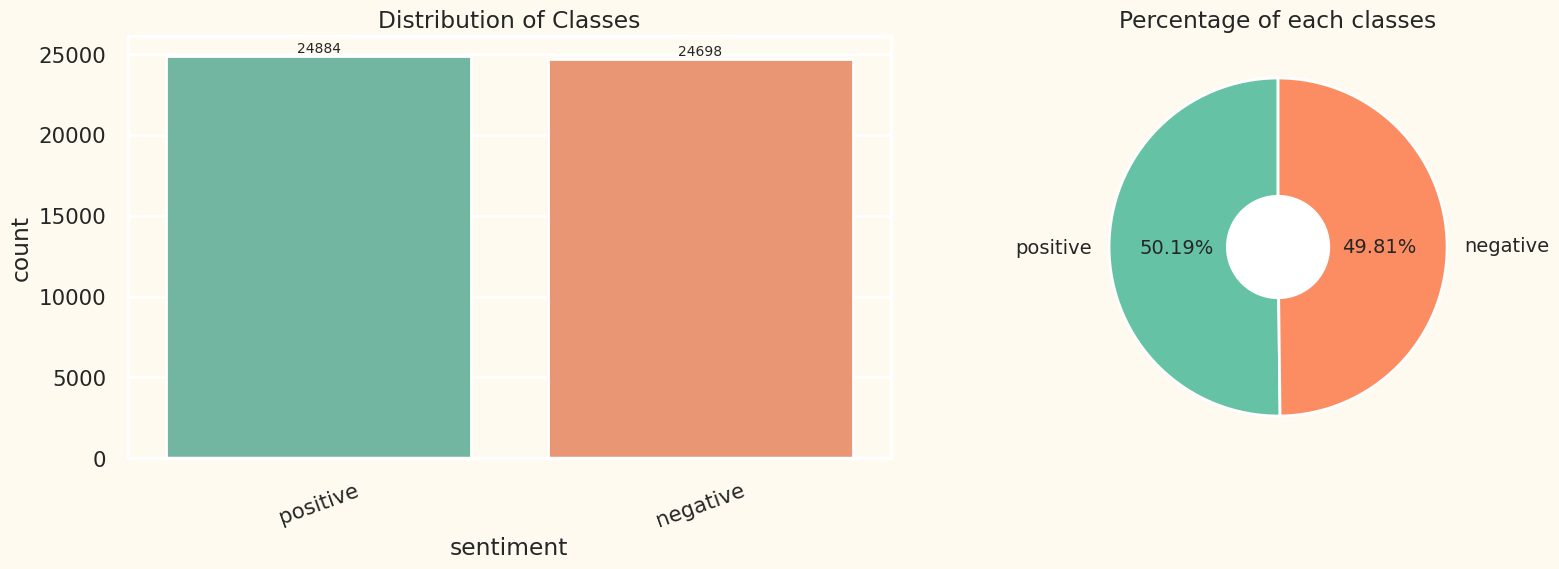

In [14]:
classes = df.select(pl.col('sentiment')).unique().to_series().to_list()

# plt.figure(figsize=(17, 6))
fig, axes = plt.subplots(1, 2, figsize=(17,6))
sentiment_counts = df.get_column('sentiment').value_counts().to_pandas()
# reorder rows to matches classes
sentiment_counts=  sentiment_counts.set_index('sentiment').loc[classes].reset_index()
sns.barplot(x='sentiment', y='count',
            data=sentiment_counts,
           palette='Set2', order=classes, ax=axes[0])
axes[0].set_title('Distribution of Classes')

for _, row in enumerate(sentiment_counts.iterrows()):
    sentiment = row[1]['sentiment']
    count = row[1]['count']
    x_pos = classes.index(sentiment)
    axes[0].text(x=x_pos,
                y=row[1]['count'] + 0.5,
                s=str(count),
                 ha='center', va='bottom',
                 fontsize=10
                )
axes[0].tick_params(axis='x', rotation=20)
colors=sns.color_palette('Set2', len(classes))
plt_pie = axes[1].pie(
    sentiment_counts['count'], labels=classes, autopct='%.2f%%',
    textprops={'size': 14},
    colors=colors, startangle=90,
)
center_circle= plt.Circle((0,0), 0.3, fc='white')
axes[1].add_artist(center_circle)
axes[1].set_title("Percentage of each classes")

plt.tight_layout()
plt.show()

# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Preprocessing</div>

In [15]:
df2 = df

#### 1. Lowercasing

In [16]:
# step1 lowercasing
df2 = df2.with_columns([
    pl.col('review').str.to_lowercase().alias('review')
])
df2

review,sentiment
str,str
"""this movie is a great film. th…","""positive"""
"""""two wildlife photographers ar…","""negative"""
"""low budget ""films"" like this j…","""negative"""
"""in my case i liked this movie …","""positive"""
"""i went and saw rivers and tide…","""positive"""
…,…
"""blade is a dark, gloomy, but s…","""positive"""
"""there are some things i will n…","""positive"""
"""""d.o.a."" is a non-thrilling th…","""negative"""


#### 2. Remove HTML tags

let's take a look at those reivew with html tags

In [17]:
examples = df.filter(
    pl.col('review').str.contains(r'<[^>]+>')
).select('review')

examples

review
str
"""""Two wildlife photographers ar…"
"""I went and saw Rivers and Tide…"
"""Bloody awful! There's just no …"
"""The movie started off strong, …"
"""House of Dracula was made towa…"
…
"""I just blew four dollars renti…"
"""Blade is a dark, gloomy, but s…"
"""""D.O.A."" is a non-thrilling th…"


About 28968 reviews has html tags

In [18]:
examples = df2.filter(
    pl.col('review').str.contains(r'<[^>]+>')
).select('review').head(3).to_series()

for item in examples:
    print(item)
    print("="*25 + "\n")

"two wildlife photographers are traveling through the amazon river basin on their latest assignment. while trying to capture the wildlife of the area on film, our photographers cross paths with a game hunter, who is stalking the animals for another reason. looking to eliminate the witnesses to his illegal activities, the hunter decides to" according to the dvd sleeve's synopsis. <br /><br />handsome guide peter brown (as jim pendrake) takes pretty blonde ahna capri (as terry greene) and her good-looking brother tom simcox (as art greene) into the venezuelan jungle, to admire the view, and take wildlife pictures. after they hook up with hunky big-game hunter william smith (as caribe), psychological dramatics surface. <br /><br />a pivotal scene, with mr. brown reposing in the "vee" of a tree, and sharing a cigarette with mr. simcox, is nicely staged. the circular direction reappears in the later "fight" between brown and mr. smith; and, it is effective. simcox' early sex romp adds noth

In [19]:
import re

def remove_html_tags(text):
    # pattern = r'[^a-zA-Z0-9\s]'
    # text = re.sub(pattern,'', text)
    return re.sub(r'<.*?>', '', text)

df2 = df2.with_columns([
    pl.col('review').map_elements(remove_html_tags).alias('review')
])

df2.item(0, 'review')

"this movie is a great film. the movie shows so many themes all in one amazing film. driving lessons centers around ben (rupert grint) a shy 17 year old who is coming of age. the movie goes on about how ben is sick of his dominating mother and how he just wants to be himself. ben then meets evie, who he makes a very special bond with. the two take a journey and in the process ben finds himself and what a relationship that he and evie share. this is the movie that you watch by yourself, or with someone else. no matter what, you will all feel what ben goes through in the movie. it is a very heart warming film that just makes you think whether your driving lessons were ever as emotional or as much of a journey as ben's lessons."

#### 3. Removing URLs

Review some samples that has urls

In [20]:
examples = df.filter(
    pl.col('review').str.contains(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)')
).select('review')

examples

review
str
"""This 1955 heist film follows T…"
"""Walt Disney's ""The Rookie"" is …"
"""Written and acted by sincere a…"
"""This film may be great, but it…"
"""I just saw this movie on HBO, …"
…
"""As is well-known among long ha…"
"""""Scientists at a remote lab ex…"
"""Alone in the Dark is Uwe Boll'…"


about 119 reviews contain URLs

In [21]:
examples.item(0, 'review')

"This 1955 heist film follows Tony le Stephanois, recently released from prison for theft, as he undertakes the robbery of his life. He teams up with his old heist buddies and they bring in an expert safe-cracker, Cesar from Milan (played by Jules Dassin, who also directed. He only directed because he had been blacklisted as a communist in the U.S. and couldn't work in Hollywood.) The brilliance of this film is the 1/2 hour during the robbery. During all this time, there is no dialogue and no music, only the muted sounds of digging through the floor or drilling the safe. This increases the suspense and draws you in. They get away with several hundred million francs worth of jewels, but a jewel offered to a dancer by Cesar brings their haul to the attention of a trio of brutal brothers. They set out to get the stash for themselves and bring misfortune in their wake. Great heist/gangster movie, but I prefer J.-P. Melville's films in this genre.<br /><br />This movie is like some lemonade

In [22]:
def remove_urls(text):
    return re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)', '', text)

df2 = df2.with_columns([
    pl.col('review').map_elements(remove_urls).alias('review')
])
df2.item(1, 'review')

'"two wildlife photographers are traveling through the amazon river basin on their latest assignment. while trying to capture the wildlife of the area on film, our photographers cross paths with a game hunter, who is stalking the animals for another reason. looking to eliminate the witnesses to his illegal activities, the hunter decides to\x85" according to the dvd sleeve\'s synopsis. handsome guide peter brown (as jim pendrake) takes pretty blonde ahna capri (as terry greene) and her good-looking brother tom simcox (as art greene) into the venezuelan jungle, to admire the view, and take wildlife pictures. after they hook up with hunky big-game hunter william smith (as caribe), psychological dramatics surface. a pivotal scene, with mr. brown reposing in the "vee" of a tree, and sharing a cigarette with mr. simcox, is nicely staged. the circular direction reappears in the later "fight" between brown and mr. smith; and, it is effective. simcox\' early sex romp adds nothing to the story; 

#### 4. Remove Punctuation

In [23]:
import string, time
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
def remove_punctuation(text):
    return text.translate(str.maketrans('','', string.punctuation))

df2 = df2.with_columns([
    pl.col('review').map_elements(remove_punctuation).alias('review')
])

df2.item(0, 'review')

'this movie is a great film the movie shows so many themes all in one amazing film driving lessons centers around ben rupert grint a shy 17 year old who is coming of age the movie goes on about how ben is sick of his dominating mother and how he just wants to be himself ben then meets evie who he makes a very special bond with the two take a journey and in the process ben finds himself and what a relationship that he and evie share this is the movie that you watch by yourself or with someone else no matter what you will all feel what ben goes through in the movie it is a very heart warming film that just makes you think whether your driving lessons were ever as emotional or as much of a journey as bens lessons'

#### 5. Chat word treatment

In [25]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "LOL": "Laughing out loud",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don’t care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "IDC": "I don’t care",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "LMAO": "Laughing my a** off",
    "BFF": "Best friends forever",
    "CSL": "Can’t stop laughing",
}


Let's log out some samples with those ABBRIEVIATION 

In [26]:
chat_words_set = set(word.lower() for word in chat_words.keys())
def contain_chat_words(text):
    words = text.lower().split()
    
    return any(word in chat_words_set for word in words)

examples = df2.filter(
    pl.col('review').map_elements(contain_chat_words)
)

lst = []
for i in range(examples.height):  
    text = examples.item(i, 'review')
    # print(text)
    words = text.lower().split()
    for word in words:
        if word in chat_words_set and word != 'time':
            lst.append([word, i])
print(len(lst))

1567


In [27]:
examples.item(20, 'review')

'alexandra maria lara a very beautiful and enticing woman but not a good actress in all the films ive seen her in she appears to me as the exact same character whether it be in the downfall nackt vom suchen und finden der liebe and now wo ist fred she always is plays the young goodhearted woman who is a little naive and doesnt know how to handle the things happening to her she disposes of a repertoire of probably five different facial expressions that she works with abundantly i personally have a hard time believing that she could play a mysterious and slightly obnoxious character because it just isnt in here so shes typecast as the nice girl next door which she is but once again she aint up to snuff when it comes to acting til schweiger same thing the film downright stupid as it was an american movie it would have been a great role for adam sandler who i dont like either i wasnt offended by the fact that this is a film with handicapped people in it i just thought that the jokes result

In [28]:
def chat_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words:
            new_text.append(chat_words.get(w.upper()))
        else:
            new_text.append(w)
    return " ".join(new_text)

df2 = df2.with_columns([
    pl.col('review').map_elements(chat_conversion)
])

df2

review,sentiment
str,str
"""this movie is a great film the…","""positive"""
"""two wildlife photographers are…","""negative"""
"""low budget films like this jus…","""negative"""
"""in my case i liked this movie …","""positive"""
"""i went and saw rivers and tide…","""positive"""
…,…
"""blade is a dark gloomy but sig…","""positive"""
"""there are some things i will n…","""positive"""
"""doa is a nonthrilling thriller…","""negative"""


#### 7. Removing Stopwords

In [29]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import random
random.sample(stop_words, k=5)

['didn', "she'd", 'further', 'yourself', 'had']

remvoe stopwords

In [30]:
def stopwords_removal(text):
    new_text = []
    for word in text.split():
        if word in stop_words:
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:] # get all items
    new_text.clear()
    return " ".join(x)

df2 = df2.with_columns(
    pl.col('review').map_elements(stopwords_removal)
)
df2

review,sentiment
str,str
""" movie great film movie sho…","""positive"""
"""two wildlife photographers tr…","""negative"""
"""low budget films like give …","""negative"""
""" case liked movie saw …","""positive"""
""" went saw rivers tides toda…","""positive"""
…,…
"""blade dark gloomy significe…","""positive"""
""" things never understand …","""positive"""
"""doa nonthrilling thriller d…","""negative"""


#### 8. Removing Emojis

In [31]:
def contains_emoji(text):
    return bool(re.search(r"["                                  
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]", text))

# Step 2: Apply filter and log some samples
df_with_emoji = df2.filter(
    pl.col("review").map_elements(contains_emoji)
)
df_with_emoji.item(3, 'review')

' damsel  distress  definitely  one  fred astaires better musicals  even astaires bad films always   good momentsin damsel astaire  jerry halliday  american musical star    london   personal appearance tour  meets lady alice marshmorton 19yearold joan fontaine  beautiful english heiress  hops   back   cab   taking  escape  mob  admirersjerry believes  alice   forced   marriage   rich aunt  tries  rescue    familys country manor house  soon discovers   house staff  laying bets   suitor lady alice  marry keggs reginald gardiner  conniving butler  albert harry watson  bratty house boy  take turns alternately helping  sabotaging lady alices romance  jerry  make sure  win  betthis musical  numerous problems first    plot based   novel  pg wodehouse  cowrote  screenplay  story  slow painful  nervegrating  fred   dancing    endure endless annoying scenes   fred romancing joan fontaine  b keggs  albert conniving     otherthe butler   house boy  especially irritating   onedimensional stock vill

In [32]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df2 = df2.with_columns(
    pl.col('review').map_elements(remove_emoji)
)
df2

review,sentiment
str,str
""" movie great film movie sho…","""positive"""
"""two wildlife photographers tr…","""negative"""
"""low budget films like give …","""negative"""
""" case liked movie saw …","""positive"""
""" went saw rivers tides toda…","""positive"""
…,…
"""blade dark gloomy significe…","""positive"""
""" things never understand …","""positive"""
"""doa nonthrilling thriller d…","""negative"""


#### 9.Remove contractions

In [33]:
import contractions
contractions.fix("I can't do this. It's not right.")

'I cannot do this. It is not right.'

In [34]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

df2 = df2.with_columns([
    pl.col('review').map_elements(expand_contractions)
])
df2

review,sentiment
str,str
""" movie great film movie sho…","""positive"""
"""two wildlife photographers tr…","""negative"""
"""low budget films like give …","""negative"""
""" case liked movie saw …","""positive"""
""" went saw rivers tides toda…","""positive"""
…,…
"""blade dark gloomy significe…","""positive"""
""" things never understand …","""positive"""
"""doa nonthrilling thriller d…","""negative"""


#### 10. Lemmatize

In [35]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)

for token in doc:
    print(token, token.lemma_, sep=': ')

this: this
german: german
documentary: documentary
in: in
english: english
is: be
about: about
a: a
scottish: scottish
environmental: environmental
sculptor: sculptor
named: name
andy: andy
goldsworthy: goldsworthy
he: he
makes: make
art: art
from: from
objects: object
he: he
finds: find
in: in
nature: nature
for: for
example: example
early: early
in: in
the: the
film: film
we: we
see: see
him: he
taking: take
sections: section
of: of
icicles: icicle
and: and
gluing: glue
them: they
together: together
with: with
a: a
little: little
moisture: moisture
into: into
a: a
serpentine: serpentine
shape: shape
that: that
seems: seem
to: to
repeatedly: repeatedly
go: go
through: through
a: a
vertical: vertical
rockof: rockof
course: course
the: the
icicles: icicle
melt: melt
but: but
that: that
transience: transience
is: be
a: a
part: part
of: of
most: most
of: of
goldsworthys: goldsworthys
work: work
he: he
goes: go
to: to
a: a
site: site
and: and
gets: get
a: a
feeling: feeling
for: for
it: it

In [36]:
nlp = spacy.load("en_core_web_sm")
def lemmatize_text(text):
    doc = nlp(text)
    lemmatize_text = ' '.join([token.lemma_ for token in doc])
    return lemmatize_text
def lemmatize_review(df):
    df = df.with_columns([
        pl.col('review').map_elements(lemmatize_text)
    ])
    return df

df2 = lemmatize_review(df2)


In [37]:
df2

review,sentiment
str,str
""" movie great film movie …","""positive"""
"""two wildlife photographer tr…","""negative"""
"""low budget film like give …","""negative"""
""" case like movie saw…","""positive"""
""" go see river tide toda…","""positive"""
…,…
"""blade dark gloomy signifi…","""positive"""
""" thing never understand …","""positive"""
"""doa nonthrille thriller d…","""negative"""


#### 11. Tokenize the text

In [38]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
text = "He bought 2 apples, 3 bananas, and 1 mango."
tokens = word_tokenize(text)
print(tokens)

['He', 'bought', '2', 'apples', ',', '3', 'bananas', ',', 'and', '1', 'mango', '.']


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
def tokenize(text):
    token_words = word_tokenize(text)
    return token_words

df2 = df2.with_columns([
    pl.col('review').map_elements(tokenize)
])
df2

review,sentiment
list[str],str
"[""movie"", ""great"", … ""lesson""]","""positive"""
"[""two"", ""wildlife"", … ""would""]","""negative"""
"[""low"", ""budget"", … ""plague""]","""negative"""
"[""case"", ""like"", … ""thank""]","""positive"""
"[""go"", ""see"", … ""tide""]","""positive"""
…,…
"[""blade"", ""dark"", … ""viewing87""]","""positive"""
"[""thing"", ""never"", … ""laughter""]","""positive"""
"[""doa"", ""nonthrille"", … ""age""]","""negative"""


# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Splitting dataset</div>

In [40]:
X = df2['review']
y = df2['sentiment']
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

(49582,) (49582,)
shape: (5,)
Series: 'review' [list[str]]
[
	["movie", "great", … "lesson"]
	["two", "wildlife", … "would"]
	["low", "budget", … "plague"]
	["case", "like", … "thank"]
	["go", "see", … "tide"]
]
shape: (5,)
Series: 'sentiment' [str]
[
	"positive"
	"negative"
	"negative"
	"positive"
	"positive"
]


In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
transformed_y = encoder.fit_transform(y)
print(transformed_y[:5])
X.shape[0]

[1 0 0 1 1]


49582

In [42]:
from sklearn.model_selection import train_test_split

def my_train_and_test_split(X, y, test_size=0.2):
    """
    Args: X and y are polars series
    """
    num_test_samples = int(test_size * X.shape[0])
    # num_train_samples = X.height - num_test_samples
    indices = np.random.permutation(X.shape[0])
    
    X_test, y_test = X[indices[:num_test_samples]], y[indices[:num_test_samples]]
    X_train, y_train = X[indices[num_test_samples:]], y[indices[num_test_samples:]]

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = my_train_and_test_split(X, transformed_y, test_size=0.2)
print(f"X train shape = {X_train.shape}")
print(f"y train shape = {y_train.shape}")
print(f"X test shape = {X_test.shape}")
print(f"y test shape = {y_test.shape}")

X train shape = (39666,)
y train shape = (39666,)
X test shape = (9916,)
y test shape = (9916,)


In [43]:
X_train

review
list[str]
"[""summarize"", ""movie"", … ""2""]"
"[""can"", ""not"", … ""skill""]"
"[""dreadful"", ""film"", … ""downhill""]"
"[""usually"", ""do"", … ""show""]"
"[""first"", ""get"", … ""entertainment""]"
…
"[""I"", ""be"", … ""trueshelly""]"
"[""parent"", ""take"", … ""video""]"
"[""1969"", ""year"", … ""eye""]"


In [44]:
print(type(X_train))
print(type(y_test))
X_train_lst = X_train.to_list()
X_test_lst = X_test.to_list()

<class 'polars.series.series.Series'>
<class 'numpy.ndarray'>


# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Tokenize Data</div>

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<oov>')

tokenizer.fit_on_texts(X_train_lst)
print(f"vocab size = {len(tokenizer.word_index)}")
print(f"number of document (equivalent to X_train.shape) = {tokenizer.document_count}")

print("[INFO]: Begin the process of tokenizing")
tokenized_X_train = tokenizer.texts_to_sequences(X_train_lst)
tokenized_X_test = tokenizer.texts_to_sequences(X_test_lst)
print("[INFO]: Tokenizing done!")

for num in tokenized_X_train[0]:
    print(num, end=' ')
print()
print(f"Dimension of each sequences:  {len(tokenized_X_train[0])}")

vocab size = 174972
number of document (equivalent to X_train.shape) = 39666
[INFO]: Begin the process of tokenizing
[INFO]: Tokenizing done!
5351 2 123 73 50 2 1599 580 106 3910 15 283 1368 8 19 318 131 309 368 6 4 77 485 15 9188 1454 786 4241 47 2 81 110 2610 60 70 220 23 1368 465 78 849 493 46 2322 209 4241 36 2 89 128 218 2655 2 160 370 61080 1156 15 5 11 43 2 243 29 95 10 4 17 2 10 4 1296 10370 560 443 3807 10 4 420 154 225 
Dimension of each sequences:  81


In [46]:
len(tokenized_X_train[3])

105

# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Padding Data</div>

In [47]:
max_length = 0
for sequence in tokenized_X_train:
    max_length = len(sequence) if max_length < len(sequence) else max_length
print(f"[INFO]: Maximum sequence length: {max_length}")


from tensorflow.keras.preprocessing.sequence import pad_sequences
preprocessed_X_train = pad_sequences(tokenized_X_train, padding='post')
preprocessed_X_test = pad_sequences(tokenized_X_test, padding='post')

print(f"length of first entry of preprocessed_X_train: = {len(preprocessed_X_train[0])}")
print(f"preprocessed_X_train[0]: \n {preprocessed_X_train[0]}")

[INFO]: Maximum sequence length: 1446
length of first entry of preprocessed_X_train: = 1446
preprocessed_X_train[0]: 
 [5351    2  123 ...    0    0    0]


# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Saving the data for later use</div>

In [48]:
import numpy as np
# X strain shape = (39666, 1446)
# X test shape = (9916, 1446)
# 418 samples are duplicates
np.save('X_train.npy', preprocessed_X_train)
np.save('X_test.npy', preprocessed_X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [49]:
xte =  np.load('/kaggle/working/X_test.npy', allow_pickle=True)
xtr = np.load('/kaggle/working/X_train.npy', allow_pickle=True)
assert preprocessed_X_train.shape == xtr.shape
preprocessed_X_train.shape

(39666, 1446)

# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Modelling</div>

# <div style="background-color: aliceblue; font-family: san-serif, arial; text-align: center; border-radius: 25px;">Bidirectional RNN</div>

In [50]:
!pip install -q mlflow
!pip install -q pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00


In [51]:
RNN_model = Sequential()